# 인물사진 만들기

DeepLab v3+ 모델을 사용하여 인물사진을 만들어보도록 하겠습니다.

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### 오늘은 총 3장의 인물사진을 만들어 볼 것입니다.
1. 내사진 2. 고양이사진 3. 배경을 합성한 인물사진

In [3]:
import os
folder_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
img_path_1 = folder_path + 'my_img_1.jpg'
img_path_2 = folder_path + 'cat.jpg'
img_path_3 = folder_path + 'my_img_2.jpg'
img_path_4 = folder_path + 'background.jpg'

img_orig_1 = cv2.imread(img_path_1)
img_orig_2 = cv2.imread(img_path_2)
img_orig_3 = cv2.imread(img_path_3)
img_orig_4 = cv2.imread(img_path_4)

print (img_orig_1.shape)
print (img_orig_2.shape)
print (img_orig_3.shape)
print (img_orig_4.shape)

(960, 720, 3)
(548, 550, 3)
(960, 720, 3)
(866, 1300, 3)


DeepLab 모델을 준비하겠습니다. 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.

DeepLab Demo : https://github.com/tensorflow/models/blob/master/research/deeplab/

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [6]:
img_resized_1, seg_map_1 = MODEL.run(img_orig_1)
print (img_orig_1.shape, img_resized_1.shape, seg_map_1.max())

(960, 720, 3) (513, 384, 3) 15


#cv2는 채널을 HWC 순서로 표시합니다.

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 세그멘테이션 결과

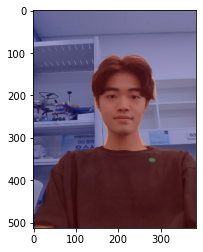

In [8]:
img_show_1 = img_resized_1.copy()
seg_map_1 = np.where(seg_map_1 == 15, 15, 0) # 예측 중 사람만 추출
img_mask_1 = seg_map_1 * (255/seg_map_1.max()) # 255 normalization
img_mask_1 = img_mask_1.astype(np.uint8)
color_mask_1 = cv2.applyColorMap(img_mask_1, cv2.COLORMAP_JET)
img_show_1 = cv2.addWeighted(img_show_1, 0.6, color_mask_1, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_1, cv2.COLOR_BGR2RGB))
plt.show()

### 세그멘테이션 결과를 원래 사이즈로 복원하기

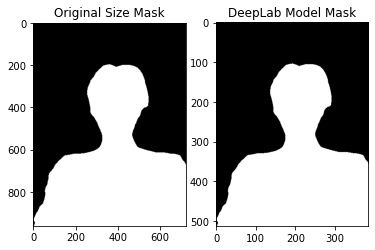

In [9]:
img_mask_up_1 = cv2.resize(img_mask_1, img_orig_1.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_1 = cv2.threshold(img_mask_up_1, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_1, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_1, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경만 추출하기

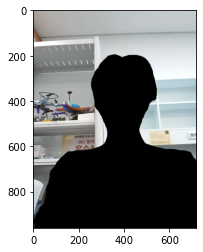

In [10]:
img_mask_color_1 = cv2.cvtColor(img_mask_up_1, cv2.COLOR_GRAY2BGR)
img_bg_mask_1 = cv2.bitwise_not(img_mask_color_1)
img_bg_1 = cv2.bitwise_and(img_orig_1, img_bg_mask_1)
plt.imshow(img_bg_1)
plt.show()

### 블러처리하기

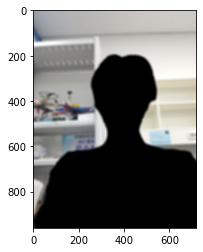

In [11]:
img_bg_blur_1 = cv2.blur(img_bg_1, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur_1, cv2.COLOR_BGR2RGB))
plt.show()

### 원본 사진에 합성하기

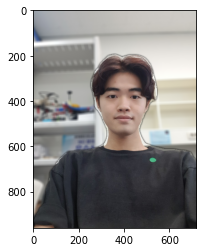

In [12]:
img_concat_1 = np.where(img_mask_color_1==255, img_orig_1, img_bg_blur_1)
plt.imshow(cv2.cvtColor(img_concat_1, cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite('New_my_img_1.jpg',img_concat)

Todo:  
경계선이 매끄럽지 못한것 같습니다. 이걸 해결할 수 있는 방안을 찾아보도록 하겠습니다.

# 2 고양이 인물사진 만들기

In [13]:
img_resized_2, seg_map_2 = MODEL.run(img_orig_2)
print (img_orig_2.shape, img_resized_2.shape, seg_map_2.max())

(548, 550, 3) (511, 513, 3) 8


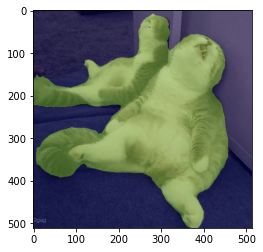

In [14]:
img_show_2 = img_resized_2.copy()
seg_map_2 = np.where(seg_map_2 == 8, 8, 0) # 예측 중 고양이만 추출
img_mask_2 = seg_map_2 * (255/seg_map_1.max()) # 255 normalization
img_mask_2 = img_mask_2.astype(np.uint8)
color_mask_2 = cv2.applyColorMap(img_mask_2, cv2.COLORMAP_JET)
img_show_2 = cv2.addWeighted(img_show_2, 0.6, color_mask_2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))
plt.show()

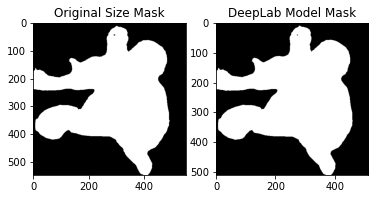

In [15]:
img_mask_up_2 = cv2.resize(img_mask_2, img_orig_2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_2 = cv2.threshold(img_mask_up_2, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

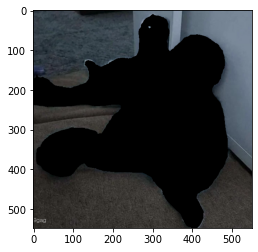

In [16]:
img_mask_color_2 = cv2.cvtColor(img_mask_up_2, cv2.COLOR_GRAY2BGR)
img_bg_mask_2 = cv2.bitwise_not(img_mask_color_2)
img_bg_2 = cv2.bitwise_and(img_orig_2, img_bg_mask_2)
plt.imshow(img_bg_2)
plt.show()

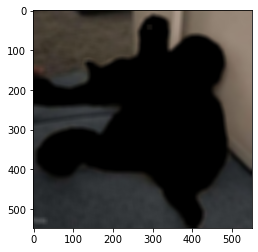

In [17]:
img_bg_blur_2 = cv2.blur(img_bg_2, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur_2, cv2.COLOR_BGR2RGB))
plt.show()

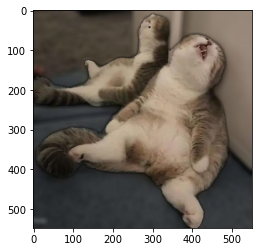

In [18]:
img_concat_2 = np.where(img_mask_color_2==255, img_orig_2, img_bg_blur_2)
plt.imshow(cv2.cvtColor(img_concat_2, cv2.COLOR_BGR2RGB))
plt.show()

Todo:  
사진이 전체적으로 어두워서 그런지 경계선에서 티가 안나는 듯합니다..??  
하지만 1,3번 사진에 맞추어 테두리 작업을 할 필요가 있어 보입니다. 

# 3. 배경전환 크로마키사진만들기

In [19]:
img_resized_3, seg_map_3 = MODEL.run(img_orig_3)
print(img_orig_3.shape, img_resized_3.shape, seg_map_3.max())

img_resized_4 = cv2.resize(img_orig_4, (img_orig_3.shape[1],img_orig_3.shape[0]))
print(img_orig_4.shape, img_resized_4.shape)

(960, 720, 3) (513, 384, 3) 15
(866, 1300, 3) (960, 720, 3)


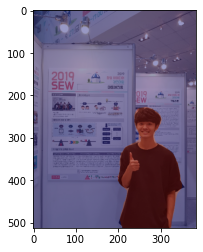

In [20]:
img_show_3 = img_resized_3.copy()
seg_map_3 = np.where(seg_map_3 == 15, 15, 0) # 예측 중 사람만 추출
img_mask_3 = seg_map_3 * (255/seg_map_1.max()) # 255 normalization
img_mask_3 = img_mask_3.astype(np.uint8)
color_mask_3 = cv2.applyColorMap(img_mask_3, cv2.COLORMAP_JET)
img_show_3 = cv2.addWeighted(img_show_3, 0.6, color_mask_3, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_3, cv2.COLOR_BGR2RGB))
plt.show()

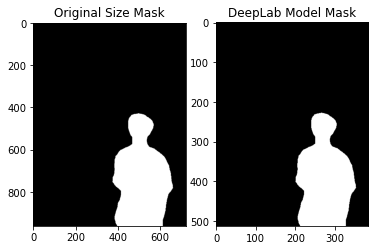

In [21]:
img_mask_up_3 = cv2.resize(img_mask_3, img_orig_3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up_3 = cv2.threshold(img_mask_up_3, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_3, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

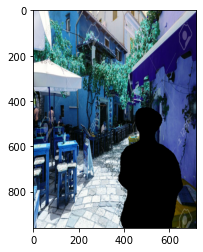

In [22]:
img_mask_color_3 = cv2.cvtColor(img_mask_up_3, cv2.COLOR_GRAY2BGR)
img_bg_mask_3 = cv2.bitwise_not(img_mask_color_3)
img_bg_3 = cv2.bitwise_and(img_resized_4, img_bg_mask_3)
plt.imshow(img_bg_3)
plt.show()

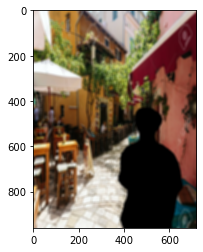

In [23]:
img_bg_blur_3 = cv2.blur(img_bg_3, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur_3, cv2.COLOR_BGR2RGB))
plt.show()

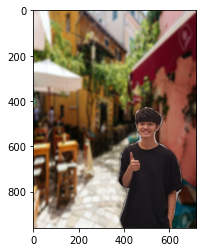

In [24]:
img_concat_3 = np.where(img_mask_color_3==255, img_orig_3, img_bg_blur_3)
plt.imshow(cv2.cvtColor(img_concat_3, cv2.COLOR_BGR2RGB))
plt.show()

Todo:  
원본사진에 맞춰 배경을 줄였더니 뒷배경이 비틀렸습니다.  
또한 합성한 테두리가 어설프게 남아있습니다. 따라서 이것을 해결할 필요가 있어 보입니다. 

# 결과 및 총평

DeepLab v3+모델을 사용하여 사진에 Shallow focus기법을 적용하는 작업을 해보았습니다.  
전체적으로 어두운사진의 경우에는 합성시에 경계선이 티가 잘 나지 않아 보이지만 밝은 사진의 경우에는 이를 해결할 필요가 있어 보입니다.
Futher Works: 경계선 문제 해결하기, 배경합성 자연스럽게 만들기